In [1]:
import matplotlib.pyplot as plt
import os
import caffe
import numpy as np

root='D:\VOC_HY\scene_data/'   #根目录
deploy=root + 'mnist_siamese.prototxt'    #deploy文件
caffe_model=root + '_iter_5000.caffemodel'   #训练好的 caffemodel
net = caffe.Net(deploy,caffe_model,caffe.TEST)   #加载model和network


#图片预处理设置
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})  #设定图片的shape格式(1,3,28,28)
transformer.set_transpose('data', (2,0,1))    #改变维度的顺序，由原始图片(28,28,3)变为(3,28,28)
#transformer.set_mean('data', np.load(mean_file).mean(1).mean(1))    #减去均值，前面训练模型时没有减均值，这儿就不用
transformer.set_raw_scale('data', 1)    # 缩放到【0，255】之间
transformer.set_channel_swap('data', (2,1,0))   #交换通道，将图片由RGB变为BGR

img_src = root + 'scene_all'
new = np.zeros((1,10))
for file in os.listdir(img_src):
    img = root + 'scene_all/' + file
    im = caffe.io.load_image(img)  # 加载图片
    net.blobs['data'].data[...] = transformer.preprocess('data', im)  # 执行上面设置的图片预处理操作，并将图片载入到blob中
    out = net.forward()
    new = np.vstack((new, out['feat']))

print new.shape
list = np.zeros((546,10))
for i in range(546):
    list[i] = 1


(547L, 10L)


In [3]:
new = new[1:,:]

In [5]:
new.shape

(546L, 10L)

In [6]:
labels = np.zeros((546,))
for i in range(304):
    labels[i]=1
labels[304:]=2
for j in range(8):
    labels[-j-1] = j+3

In [23]:
labels.shape

(546L,)

In [35]:
feat = new
feat[labels==1]

array([[ 0.07223703, -0.35720566, -0.36958313, ...,  0.60474312,
         0.73621774,  0.07962424],
       [ 0.07717043, -0.35842657, -0.36671683, ...,  0.60429114,
         0.74117762,  0.07836101],
       [ 0.07258579, -0.3535853 , -0.37090629, ...,  0.60595512,
         0.74975836,  0.07490323],
       ..., 
       [ 0.07786483, -0.34581518, -0.36712036, ...,  0.59333563,
         0.73145628,  0.08006452],
       [ 0.07102302, -0.3481527 , -0.36585361, ...,  0.60032636,
         0.73394084,  0.08023559],
       [ 0.07566457, -0.35513625, -0.36727002, ...,  0.60616559,
         0.73877573,  0.07866416]])

In [36]:
# -*- coding: utf-8 -*-
# Make sure that caffe is on the python path:
# caffe_root = '/Users/HZzone/caffe'  # this file is expected to be in {caffe_root}/examples/siamese
import random
import matplotlib.pyplot as plt
import pylab

def cosine_distnace(v1, v2):
    cos = np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return cos

def euclidean_distance(v1, v2):
    euc = np.sqrt(np.sum(np.square(v1 - v2)))
    return euc

# 这个函数在生成测试集的时候可能会出现重复的，所以最好还是换成set而不是用tuple
def generate_accuracy_map(features, labels, totals=6000, threshold=0):
    # the number of _diff and _same = totals/2
    _diff = []
    _same = []
    unique_labels = set(labels)
    length = len(unique_labels)
    diff_features = []
    for i in range(length):
        ith_features = features[labels==i]
        diff_features.append(ith_features)
        # 每个样本平均取
        for j in range(totals/(2*length)):
            x = random.randint(0, len(ith_features)-1)
            y = random.randint(0, len(ith_features)-1)
            first = ith_features[x]
            second = ith_features[y]
            # 这是所有相同的
            _same.append(cosine_distnace(first, second))
    # 这是不相同
    # 随机抽，不会抽在同一个类中
    for j in range(totals/2):
        while True:
            x = random.randint(0, length-1)
            y = random.randint(0, length-1)
            if x != y:
                break
        first = random.randint(0, len(diff_features[x])-1)
        second = random.randint(0, len(diff_features[y])-1)
        _diff.append(cosine_distnace(diff_features[x][first], diff_features[y][second]))
    correct = 0
    for elememt in _diff:
        if elememt < threshold:
            correct = correct + 1
    for elememt in _same:
        if elememt >= threshold:
            correct = correct + 1
    return float(correct)/totals


def plot_accuracy_map(features, labels, totals=6000):
    x_vaules = pylab.arange(-1.0, 1.01, 0.01)
    y_values = []
    for x in x_vaules:
        y_values.append(generate_accuracy_map(features=features, labels=labels, threshold=x))
    max_index = np.argmax(y_values)
    print max_index
    plt.title("threshold-accuracy curve")
    plt.xlabel("threshold")
    plt.ylabel("accuracy")
    plt.plot(x_vaules, y_values)
    plt.plot(x_vaules[max_index], y_values[max_index], '.', label="(%s, %s)"%(x_vaules[max_index], y_values[max_index]))
    plt.title("Threshold-Accuracy")
    plt.xlabel("threshold")
    plt.ylabel("accuracy")
    plt.plot(x_vaules, y_values)
    plt.plot(x_vaules[max_index], y_values[max_index], '*', color='red', label="(%s, %s)"%(x_vaules[max_index], y_values[max_index]))
    plt.legend()
    plt.show()


# test dataset output n*(x, y)
feat = out['feat']
# feat = out['ip2']


# # 1 of test dataset
# one = feat[labels==1]
# # calculate euclidean distance
# acc = euclidean_distance(one[0], one[1])
# print acc

# # for each layer, show the output shape
# for layer_name, blob in net.blobs.iteritems():
#     print layer_name + '\t' + str(blob.data.shape)

# cos = cosine_distnace(one[0], one[1])
# print cos


# print generate_accuracy_map(features=feat, labels=labels, threshold=1.0)
plot_accuracy_map(feat, labels)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 546

In [20]:
import caffe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys

In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import os
os.environ['GLOG_minloglevel'] = '2'
import caffe
import numpy as np
import pylab
import random
import cv2

root='D:\VOC_HY/cjDATA/new_data/'   #根目录
deploy=root + 'caffe_model/Squeeze_SiameseNet_deploy.prototxt'    #deploy文件
caffe_model=root + 'parameters_saved/train_iter_8000.caffemodel'   #训练好的 caffemodel
net = caffe.Net(deploy,caffe_model,caffe.TEST)   #加载model和network
#图片预处理设置
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})  #设定图片的shape格式(1,3,227,227)
transformer.set_transpose('data', (2,0,1))    #改变维度的顺序，由原始图片(227,227,3)变为(3,227,227)
transformer.set_raw_scale('data', 225)    # 缩放到【0，255】之间
transformer.set_channel_swap('data', (2,1,0))   #交换通道，将图片由RGB变为BGR


In [12]:
img_src = 'D:/VOC_HY/image_test/'
fileList = os.listdir(img_src)
for i,imgFile in enumerate(fileList):
    im = caffe.io.load_image(img_src+imgFile)
    net.blobs['data'].data[...][i] = transformer.preprocess('data',im)

out = net.forward()
feat = out['feat']
print(feat.shape)



(2L, 16L)


In [13]:
feat

array([[ 0.31301457,  0.31562099, -0.01783402,  0.3909764 ,  0.28184199,
         0.16061467, -0.14296205, -0.11464181,  0.0461424 , -0.04814709,
        -0.08558377, -0.15987222, -0.14783481, -0.1468157 ,  0.16480403,
         0.1478104 ],
       [ 0.29592791,  0.29308659, -0.02701285,  0.35181621,  0.24988978,
         0.16312653, -0.138614  , -0.1028635 ,  0.04716874, -0.04454419,
        -0.06516705, -0.14282413, -0.12490353, -0.14420225,  0.1567602 ,
         0.14016213]], dtype=float32)

In [14]:
np.sum(np.square(feat[0] - feat[1]))*100

0.49797995015978813

<Container object of 16 artists>

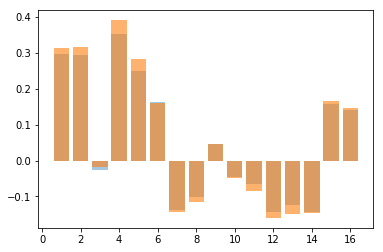

In [15]:
X = np.arange(16)+1
Y1 = feat[0]
Y2 = feat[1]
plt.bar(X,Y2,alpha=0.4)
plt.bar(X,Y1,alpha=0.6)


In [16]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (2L, 3L, 227L, 227L)),
 ('conv1', (2L, 96L, 111L, 111L)),
 ('pool1', (2L, 96L, 55L, 55L)),
 ('fire2/squeeze1x1', (2L, 16L, 55L, 55L)),
 ('fire2/squeeze1x1_fire2/relu_squeeze1x1_0_split_0', (2L, 16L, 55L, 55L)),
 ('fire2/squeeze1x1_fire2/relu_squeeze1x1_0_split_1', (2L, 16L, 55L, 55L)),
 ('fire2/expand1x1', (2L, 64L, 55L, 55L)),
 ('fire2/expand3x3', (2L, 64L, 55L, 55L)),
 ('fire2/concat', (2L, 128L, 55L, 55L)),
 ('fire3/squeeze1x1', (2L, 16L, 55L, 55L)),
 ('fire3/squeeze1x1_fire3/relu_squeeze1x1_0_split_0', (2L, 16L, 55L, 55L)),
 ('fire3/squeeze1x1_fire3/relu_squeeze1x1_0_split_1', (2L, 16L, 55L, 55L)),
 ('fire3/expand1x1', (2L, 64L, 55L, 55L)),
 ('fire3/expand3x3', (2L, 64L, 55L, 55L)),
 ('fire3/concat', (2L, 128L, 55L, 55L)),
 ('fire4/squeeze1x1', (2L, 32L, 55L, 55L)),
 ('fire4/squeeze1x1_fire4/relu_squeeze1x1_0_split_0', (2L, 32L, 55L, 55L)),
 ('fire4/squeeze1x1_fire4/relu_squeeze1x1_0_split_1', (2L, 32L, 55L, 55L)),
 ('fire4/expand1x1', (2L, 128L, 55L, 55L)),
 ('fire4/expa

In [17]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96L, 3L, 7L, 7L)),
 ('fire2/squeeze1x1', (16L, 96L, 1L, 1L)),
 ('fire2/expand1x1', (64L, 16L, 1L, 1L)),
 ('fire2/expand3x3', (64L, 16L, 3L, 3L)),
 ('fire3/squeeze1x1', (16L, 128L, 1L, 1L)),
 ('fire3/expand1x1', (64L, 16L, 1L, 1L)),
 ('fire3/expand3x3', (64L, 16L, 3L, 3L)),
 ('fire4/squeeze1x1', (32L, 128L, 1L, 1L)),
 ('fire4/expand1x1', (128L, 32L, 1L, 1L)),
 ('fire4/expand3x3', (128L, 32L, 3L, 3L)),
 ('fire5/squeeze1x1', (32L, 256L, 1L, 1L)),
 ('fire5/expand1x1', (128L, 32L, 1L, 1L)),
 ('fire5/expand3x3', (128L, 32L, 3L, 3L)),
 ('fire6/squeeze1x1', (48L, 256L, 1L, 1L)),
 ('fire6/expand1x1', (192L, 48L, 1L, 1L)),
 ('fire6/expand3x3', (192L, 48L, 3L, 3L)),
 ('fire7/squeeze1x1', (48L, 384L, 1L, 1L)),
 ('fire7/expand1x1', (192L, 48L, 1L, 1L)),
 ('fire7/expand3x3', (192L, 48L, 3L, 3L)),
 ('fire8/squeeze1x1', (64L, 384L, 1L, 1L)),
 ('fire8/expand1x1', (256L, 64L, 1L, 1L)),
 ('fire8/expand3x3', (256L, 64L, 3L, 3L)),
 ('fire9/squeeze1x1', (64L, 512L, 1L, 1L)),
 ('fire9/expand1x1',

In [18]:
#　编写一个函数，用于显示各层数据
def show_data(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('off')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



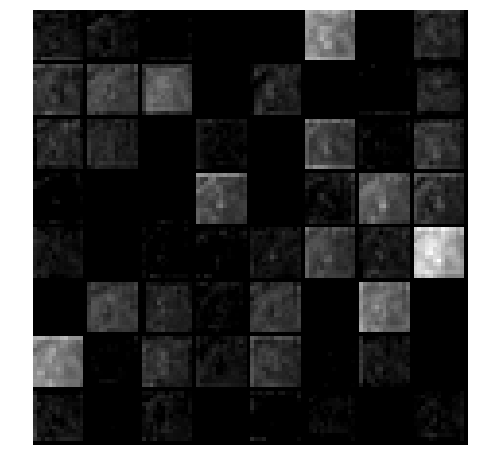

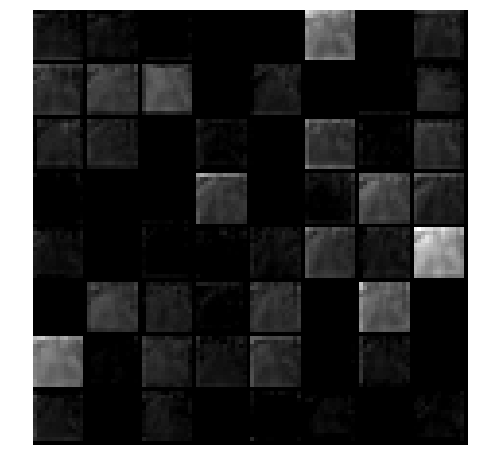

In [19]:
show_data(net.blobs['fire9/squeeze1x1'].data[0])
show_data(net.blobs['fire9/squeeze1x1'].data[1])